# Supression Method

In [58]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from scipy.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
import fair

In [9]:
train= pd.read_csv('Train_v2.csv')

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def load_data(data, s_attr):
    X= data.drop(['bank_account','uniqueid'],axis=1)
    Y= data['bank_account']
    Y=pd.Series([0 if x=='No' else 1 for x in Y])
    categorical_feature_mask = X.dtypes==object
    categorical_cols = X.columns[categorical_feature_mask].tolist()
    X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
    Z = X.loc[:, s_attr]
    #Depending on the features needed, the the next line may be commented out
#     X= X.drop([s_attr,'marital_status','relationship_with_head'],axis=1)
    return X, Y, Z

In [16]:
X,Y,Z =load_data(train,'gender_of_respondent')

## Ploting and visualising the correlation between variables

In [12]:
corr = X.corr()

In [14]:
corr

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
country,1.000000,-0.094991,0.152285,-0.150003,-0.119158,-0.058778,-0.027055,0.130408,0.009282,-0.050706,0.381066
year,-0.094991,1.000000,0.214621,-0.066505,-0.052264,-0.019330,0.000317,0.001801,-0.026187,0.173869,0.266323
location_type,0.152285,0.214621,1.000000,-0.085238,-0.257284,-0.047373,0.012924,0.017042,0.080406,0.126128,0.368606
cellphone_access,-0.150003,-0.066505,-0.085238,1.000000,0.091360,-0.103611,0.102370,-0.048705,-0.094195,0.252970,-0.146141
household_size,-0.119158,-0.052264,-0.257284,0.091360,1.000000,-0.129729,0.014576,0.104048,-0.127737,0.001613,-0.156835
age_of_respondent,-0.058778,-0.019330,-0.047373,-0.103611,-0.129729,1.000000,0.012745,-0.151477,0.222908,-0.352970,-0.102770
gender_of_respondent,-0.027055,0.000317,0.012924,0.102370,0.014576,0.012745,1.000000,-0.472048,-0.103238,0.119883,-0.029734
relationship_with_head,0.130408,0.001801,0.017042,-0.048705,0.104048,-0.151477,-0.472048,1.000000,-0.142229,-0.017141,0.041006
marital_status,0.009282,-0.026187,0.080406,-0.094195,-0.127737,0.222908,-0.103238,-0.142229,1.000000,-0.123628,0.056011
education_level,-0.050706,0.173869,0.126128,0.252970,0.001613,-0.352970,0.119883,-0.017141,-0.123628,1.000000,0.043823


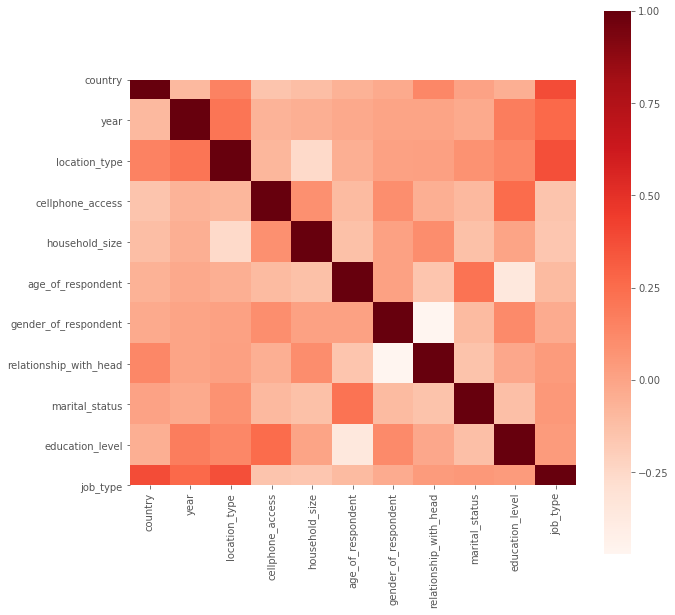

In [13]:
plt.figure(figsize=[10,10])
ax1 = sns.heatmap(corr, square=True, cmap='Reds')

### Results

Next, we split the data and check for the fairness metrics across different classifiers

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, Z_train, Z_test  = train_test_split(X, Y, Z, test_size=0.3, 
                                                                     stratify=Y, random_state=7)

In [28]:
# from sklearn.metrics import accuracy_score
# def classifier (model):
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
#     accuracy= accuracy_score(y_test, predictions)
#     aoc = roc_auc_score(y_test, predictions)
#     DPaccuracy = DP_accuracy (predictions,Z_test)
#     prule = p_rule(predictions,Z_test)
#     l={'model':model, 'Type':'data without related sens_attr', 'accuracy':accuracy,
#               'Dp':DPaccuracy,'prule':prule,' ROC_accuracy': aoc}
#     return l

In [55]:
models= [LogisticRegression(), GaussianNB(),
         DecisionTreeClassifier(random_state=0),RandomForestClassifier(random_state=0),
         xgb.XGBClassifier(),MLPClassifier(random_state=40)]
D=[]
for model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    l=fair.Get_fair_metric(model,predictions,y_test,Z_test)
    D.append(l)

/home/students/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [22]:
T=pd.DataFrame(D).T

In [15]:
T

,0,1,2,3,4,5
model,"LogisticRegression(C=1.0, class_weight=None, d...","GaussianNB(priors=None, var_smoothing=1e-09)","DecisionTreeClassifier(ccp_alpha=0.0, class_we...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","XGBClassifier(base_score=0.5, booster='gbtree'...","MLPClassifier(activation='relu', alpha=0.0001,..."
Demographic Parity,0.0399472,0.186522,0.060945,0.0811491,0.0547401,0.13548
Disparate Impact,0.617647,0.513033,0.93083,0.654378,0.588889,0.573171
Equalised_opportunity,-0.0929468,-0.246688,-0.0760923,-0.115255,-0.103557,-0.190111
Equalised_odds,-0.0111742,-0.135046,-0.0291631,-0.0421048,-0.0164717,-0.0847793
Treatment equality,0.9401,2.42208,0.729449,1.20157,1.24917,1.78276
Predictive equality,0.0111742,0.135046,0.0291631,0.0421048,0.0164717,0.0847793
Conditional Use Accuracy,-0.082943,-0.00425694,-0.0908725,-0.0245191,0.00144878,-0.013064
Overall Use Accuracy,-0.0817726,-0.111643,-0.0469293,-0.0731499,-0.0870853,-0.105332
ROC Accuracy,0.596325,0.710276,0.642507,0.663277,0.645538,0.706473


In [25]:
pd.DataFrame(D)

,model,Type,accuracy,Dp,prule,ROC_accuracy
0,"LogisticRegression(C=1.0, class_weight=None, d...",data without related sens_attr,0.873619,0.030660,0.787879,0.604299
1,"GaussianNB(priors=None, var_smoothing=1e-09)",data without related sens_attr,0.833947,0.050452,0.923313,0.711587
2,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",data without related sens_attr,0.842165,0.038753,0.947020,0.650341
3,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",data without related sens_attr,0.861859,0.040882,0.975871,0.660540
4,"XGBClassifier(base_score=0.5, booster='gbtree'...",data without related sens_attr,0.886370,0.033991,0.852459,0.651253
5,"MLPClassifier(activation='relu', alpha=0.0001,...",data without related sens_attr,0.874044,0.048462,0.845930,0.664266


## Visualision of comparism based on demographic parity and disparate impact on original data, data without sensitive attributes, data without sensitive attributes and its most correlated attributes.

In [110]:
models= ['LogisticRegression',' GaussianNB',
         'DecisionTreeClassifier','RandomForestClassifier',
         'XGBClassifier','MLPClassifier']


The values were extracted from the dataframes

In [59]:
# Original data
accuracy1 =[0.872202,0.830972,0.828705,0.865118,0.885945,0.875886]
DP1 = [0.039947, 0.186522, 0.060945, 0.081149, 0.054740, 0.092438]
Prule1= [0.617647,0.513033,0.930830,0.654378,0.588889,0.468672]
ROC1 =[0.596325, 0.710276, 0.642507, 0.663277,0.645538, 0.657768]

In [60]:
# Data without sensitive attributes
accuracy2 = [0.873194, 0.834372, 0.833097, 0.862851, 0.885803,0.862851]
DP2 = [0.035686, 0.108377,0.047690,0.064350,0.042834,0.007691]
Prule2= [0.714976, 0.782421, 0.983539,0.766169,0.733333,0.567568]
ROC2 = [0.603631, 0.708890 , 0.648849, 0.656911, 0.647979, 0.519807]

In [61]:
# Data without sensitive attributes and its most correlated attribute
accuracy3 =[0.869935,0.869793, 0.842873, 0.860300, 0.886653, 0.865401]
DP3 =[0.023686,0.026361, 0.044326, 0.043737, 0.033198,  0.059555]
Prule3= [0.792208, 0.872449, 0.993135, 0.946667, 0.858921, 0.855814]
ROC3 = [0.580286, 0.599129, 0.649491, 0.655848, 0.650997, 0.680686]

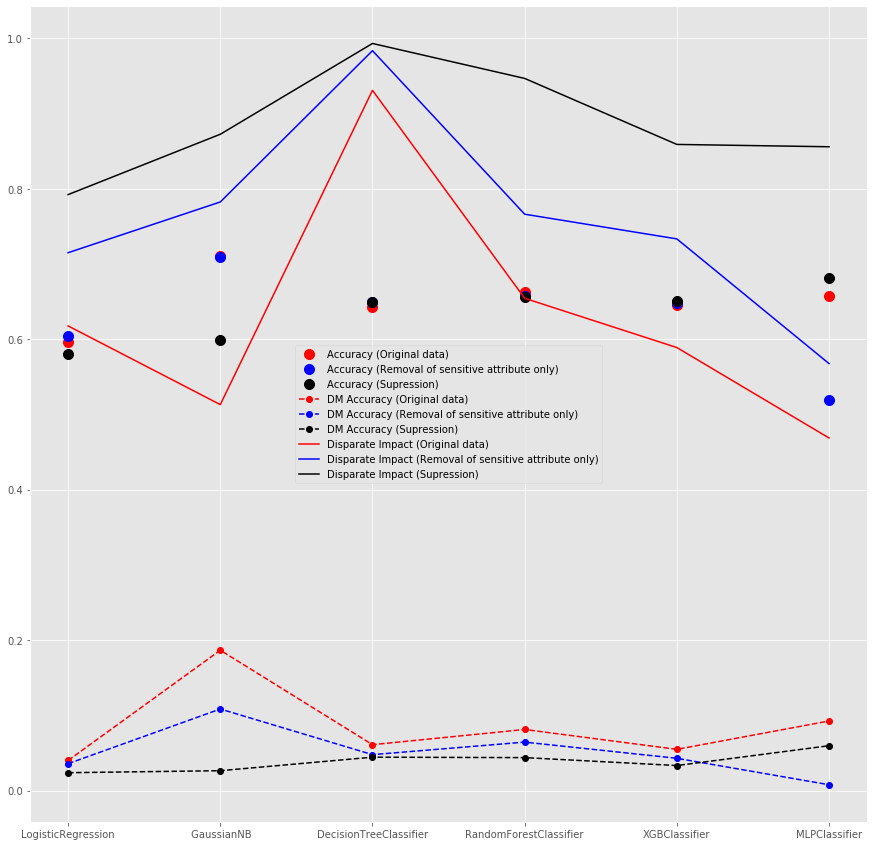

In [114]:
plt.figure(figsize=[15,15])
# plt.plot(models,accuracy1, label='Accuracy of Original data')
# plt.plot(models,accuracy2, label='Accuracy of data without sensitive attribute only')
# plt.plot(models,accuracy3, label='Accuracy of data without sensitive attribute only and correlated attributes')
plt.plot(models,ROC1,'.r',ms=20, label='Accuracy (Original data)')
plt.plot(models,ROC2,'.b',ms=20, label='Accuracy (Removal of sensitive attribute only)')
plt.plot(models,ROC3,'.k', ms=20,label='Accuracy (Supression)')

plt.plot(models,DP1,'--ro', label='DM Accuracy (Original data)')
plt.plot(models,DP2,'--bo', label='DM Accuracy (Removal of sensitive attribute only)')
plt.plot(models,DP3, '--ko',label='DM Accuracy (Supression)')
plt.plot(models,Prule1,'r', label='Disparate Impact (Original data)')
plt.plot(models,Prule2, 'b', label='Disparate Impact (Removal of sensitive attribute only)')
plt.plot(models,Prule3, 'k', label='Disparate Impact (Supression)')
plt.xlabe
plt.legend()

## Visualision of comparism based on demographic parity and disparate impact on the Original data, suppression, massaging the data and reweighing method.

In [62]:
models= ['LogisticRegression',' GaussianNB',
         'DecisionTreeClassifier','RandomForestClassifier',
         'XGBClassifier']


In [63]:
# Original data
accuracy1 =[0.872202,0.830972,0.828705,0.865118,0.885945,0.875886]
DP1 = [0.039947, 0.186522, 0.060945, 0.081149, 0.054740, 0.092438]
Prule1= [0.617647,0.513033,0.930830,0.654378,0.588889,0.468672]
ROC1 =[0.596325, 0.710276, 0.642507, 0.663277,0.645538, 0.657768]

In [64]:
# supression method
accuracy3 =[0.869935,0.869793, 0.842873, 0.860300, 0.886653]
DP3 =[0.023686,0.026361, 0.044326, 0.043737, 0.033198]
Prule3= [0.792208, 0.872449, 0.993135, 0.946667, 0.858921]
ROC3 = [0.580286, 0.599129, 0.649491, 0.655848, 0.650997]

In [65]:
# Massaging method
accuracyM= [0.8930,0.891694,0.880588,0.904106,0.95413]
ROCM= [0.621877,0.551408,0.71,0.717,0.90445]
DPM= [0.03778,0.0053399,0.081043,0.075628,0.007757]
pruleM= [0.667,0.92,0.7101,0.6092,0.47037]

In [66]:
# Reweighing method
accuracyR= [0.87,0.835,0.826,0.867,0.8865]
ROCR= [0.58,0.701,0.665,0.671,0.651]
DPR= [0.0106,0.069,0.05,0.052,0.024]
pruleR= [0.89679,0.964,0.98,0.88,0.9965]

In [98]:
# plt.figure(figsize=[15,15])
# plt.plot(models,accuracy3, label='Accuracy of Original data')
# plt.plot(models,accuracyM, label='Accuracy of data without sensitive attribute only')
# plt.plot(models,accuracyR, label='Accuracy of data without sensitive attribute only and correlated attributes')
# plt.plot(models,ROC3,'g', label='ROC Accuracy of Original data')
# plt.plot(models,ROCM,'b', label='ROC Accuracy of data without sensitive attribute only')
# plt.plot(models,ROCR,'y', label='ROC Accuracy of data without sensitive attribute only and correlated attributes')
# plt.legend()

In [99]:
# plt.figure(figsize=[15,15])
# plt.plot(models,DP3, label='DP Accuracy of Original data')
# plt.plot(models,DPM, label='DP Accuracy of data without sensitive attribute only')
# plt.plot(models,DPR, label='DP Accuracy of data without sensitive attribute only and correlated attributes')
# plt.plot(models,Prule3,'g', label='prule Accuracy of Original data')
# plt.plot(models,pruleM, 'b', label='prule Accuracy of data without sensitive attribute only')
# plt.plot(models,pruleR, 'y', label='prule Accuracy of data without sensitive attribute only and correlated attributes')

In [100]:
DP1 = [0.039947, 0.186522, 0.060945, 0.081149, 0.054740]
Prule1= [0.617647,0.513033,0.930830,0.654378,0.588889]

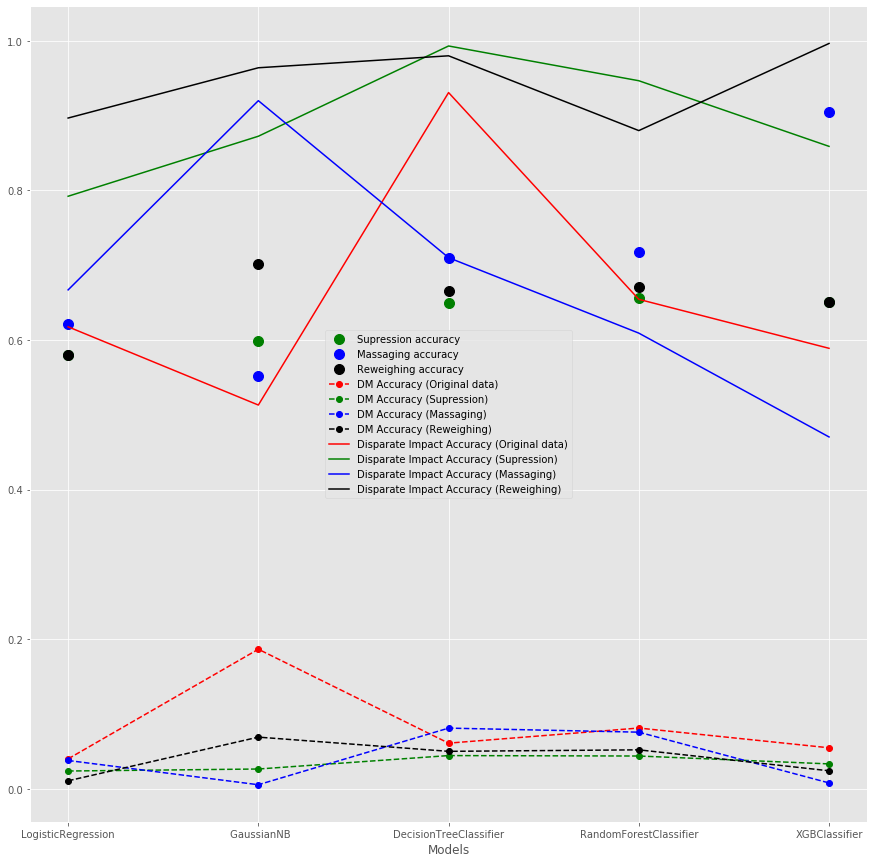

In [103]:
plt.figure(figsize=[15,15])
# plt.plot(models,accuracy1, label='Accuracy of Original data')
# plt.plot(models,accuracy2, label='Accuracy of data without sensitive attribute only')
# plt.plot(models,accuracy3, label='Accuracy of data without sensitive attribute only and correlated attributes')

plt.plot(models,ROC3,'.g',ms=20, label='Supression accuracy')
plt.plot(models,ROCM,'.b',ms=20, label='Massaging accuracy')
plt.plot(models,ROCR,'.k', ms=20,label='Reweighing accuracy')

plt.plot(models,DP1, '--ro',label='DM Accuracy (Original data) ')
plt.plot(models,DP3,'--go', label='DM Accuracy (Supression) ')
plt.plot(models,DPM,'--bo', label='DM Accuracy (Massaging)')
plt.plot(models,DPR, '--ko',label='DM Accuracy (Reweighing) ')

plt.plot(models,Prule1, 'r',label='Disparate Impact Accuracy (Original data)')
plt.plot(models,Prule3,'g', label='Disparate Impact Accuracy (Supression)')
plt.plot(models,pruleM, 'b', label='Disparate Impact Accuracy (Massaging)')
plt.plot(models,pruleR, 'k', label='Disparate Impact Accuracy (Reweighing)')
plt.xlabel('Models')
plt.legend()